In [7]:
import torch
import torch.nn as nn
from torchvision.datasets import MNIST
import tqdm 
from matplotlib import pyplot as plt
from lwot.models import Scale, GEMLinear
from lwot.utils import Loader, accuracy

In [3]:
DEV = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

train_dataset = MNIST(root='/data/ml_data', train=True, download=True)
val_dataset = MNIST(root='/data/ml_data', train=False, download=True)
train_dataset.data = train_dataset.data.float() / 255
val_dataset.data = val_dataset.data.float() / 255

trainloader = Loader(train_dataset, batch_size=-1, device=DEV)
valloader = Loader(val_dataset, batch_size=-1, device=DEV)

In [4]:
EPOCHS = 10000
hidden_dim = 100
alpha = 1e-5
scale = 2

# model = nn.Sequential(
#   nn.Flatten(),
#   GEMLinear(28*28, hidden_dim, topk=int(hidden_dim*28*28)//10),
#   nn.ReLU(),
#   GEMLinear(hidden_dim, hidden_dim, topk=int(hidden_dim*hidden_dim)//10),
#   nn.ReLU(),
#   GEMLinear(hidden_dim, 10, topk=int(hidden_dim*10)//10),
# ).to(DEV)

model = nn.Sequential(
  nn.Flatten(),
  Scale(scale, train=True, use_sigmoid=True),
  GEMLinear(28*28, hidden_dim, threshold=0.5, bias=True),
  nn.ReLU(),
  GEMLinear(hidden_dim, hidden_dim, threshold=0.5),
  nn.ReLU(),
  GEMLinear(hidden_dim, 10, threshold=0.5),
).to(DEV)

# animate saliency plot
from matplotlib.animation import FuncAnimation


pbar = tqdm.trange(EPOCHS)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2/scale*2)
for epoch in pbar:
  for x, y in trainloader:
    optimizer.zero_grad()
    y_hat = model(x)
    loss = loss_fn(y_hat, y) + alpha * sum([module.scores.pow(2).sum() for module in model if hasattr(module, 'scores')])
    loss.backward()
    optimizer.step()
  with torch.no_grad():
    acc = accuracy(y_hat, y)
    pbar.set_description(f'L: {loss.item():.3f}, A: {acc.item():.1f}')

  for x, y in valloader:
    with torch.no_grad():
      y_hat = model(x)
      loss = loss_fn(y_hat, y)
      acc = accuracy(y_hat, y)
      sparsities = [f"{module.sparsity()*100:.1f}" for module in model if hasattr(module, 'sparsity')]
      postfix = f'Val L: {loss.item():.3f}, A: {acc.item():.1f} |Sparsities: {sparsities}'
      for module in model:
        if hasattr(module, "scale"):
          postfix += f" | scale = {module.scale.item():.2f}"
      pbar.set_postfix_str(postfix)
    


L: 29.613, A: 71.4: 100%|██████████| 10000/10000 [01:24<00:00, 118.47it/s, Val L: 1.260, A: 72.3 |Sparsities: ['84.7', '70.1', '53.8'] | scale = 2.00]


In [5]:
def plot_weights(model):
    last_layer = model[-1]
    filters = last_layer.masked_weight().view(10, 28, 28)
    fig, axes = plt.subplots(1, len(filters), figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(filters[i].detach().cpu().numpy(), )
        ax.set_title(f'{i}')
    plt.show()

def saliency_map(x, y, model):
    x.requires_grad_()
    y_hat = model(x)
    loss_fn(y_hat, y).backward()
    res = - x.grad
    res = res / res.abs().max()
    return res

def plot_saliency_map(x, model, y=None):
    if y is None:
        y = model(x).argmax(dim=1)
    saliency = saliency_map(x, y, model)
    fig, axes = plt.subplots(2, len(saliency), figsize=(20, 5))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        if i < len(x):
            ax.imshow(x[i].detach().cpu().numpy())
        else:
            ax.imshow(saliency[i-len(x)].detach().cpu().numpy(), )
    plt.show()

def plot_traindata():
    X = train_dataset.data
    y = train_dataset.targets
    # group by class
    print(X.shape)
    X = [torch.mean(X[y==i], 0) for i in range(10)]
    fig, axes = plt.subplots(1, 10, figsize=(20, 5))
    for i, ax in enumerate(axes):
        ax.imshow(X[i].detach().cpu().numpy())
        ax.set_title(f'{i}')

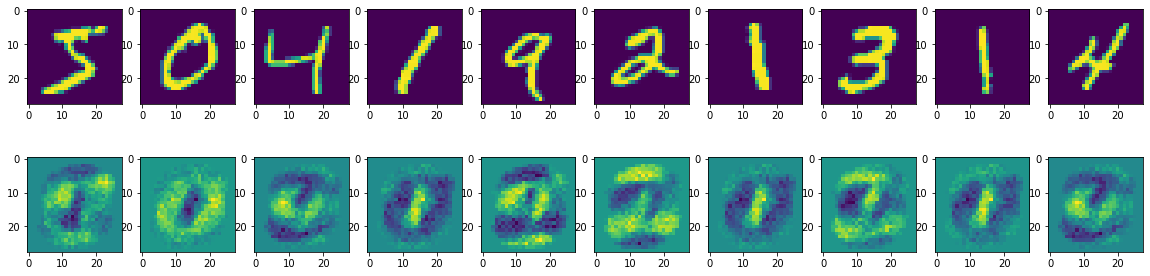

In [6]:
plot_saliency_map(train_dataset.data[:10].to(DEV), model, train_dataset.targets[:10].to(DEV))

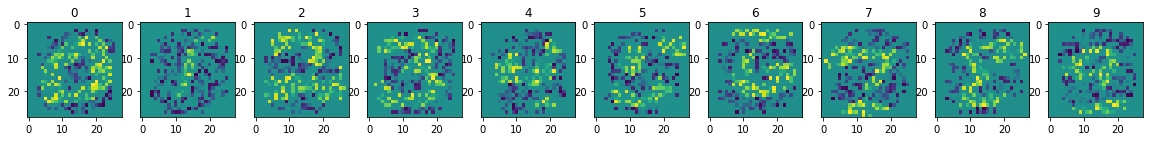

In [ ]:
plot_weights(model)

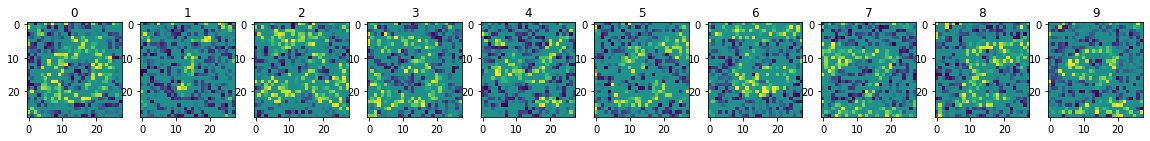

In [15]:
plot_weights(model)

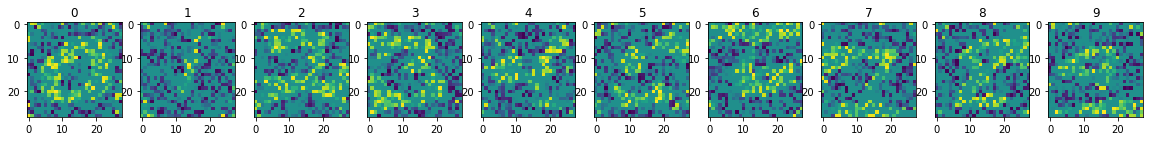

In [123]:
plot_weights(model)